In [1]:
!pip install langgraph langchain openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.7 MB/s eta 0:00:00


In [2]:
!pip install langgraph langchain langchain-community langchain-core openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00


In [3]:
!pip install langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414.3/414.3 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.8 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.37
    Uninstalling langchain-core-0.3.37:
      Successfully uninstalled langchain-core-0.3.37


In [ ]:
import os

os.environ["OPENAI_API_KEY"] = "sk-"

In [5]:
# Initialize LLM (You can replace with OpenAI, GPT-4, or a local LLM)
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4", temperature=0)

In [6]:
!pip install langgraph langchain langchain-community langchain-core openai
!pip install langchain-openai


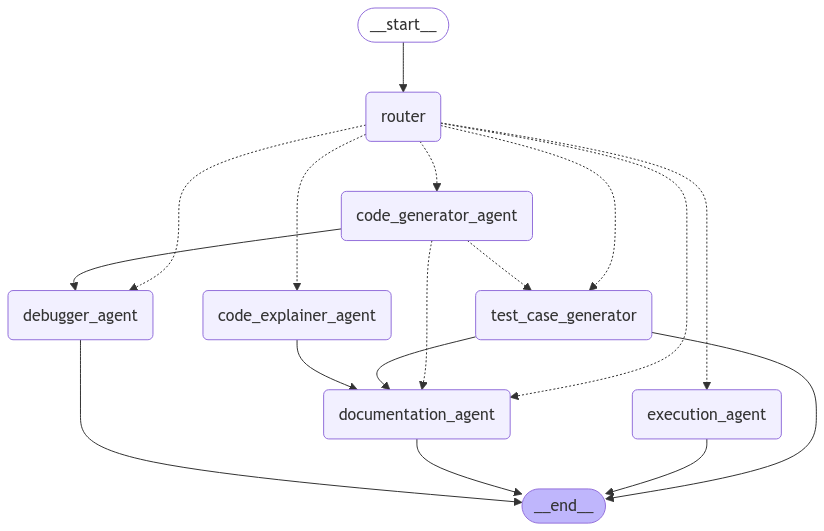

In [7]:
import sys
import io
import os
from typing import TypedDict, Literal, List
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
import re
from IPython.display import display, Image, Markdown
from langchain_core.runnables.graph import MermaidDrawMethod
import operator
from transformers import pipeline
# Set API key
os.environ["OPENAI_API_KEY"] = "sk-proj-zyt77Nwqbz8ix8BKN5R8A"

# Initialize LLM
llm = ChatOpenAI(model="gpt-4", temperature=0)
# Initialize Ollama LLM
#llm = ChatOllama(model="mistral", temperature=0, base_url="http://localhost:11434")  # Change "mistral" to your desired Ollama model
#llm = pipeline("text-generation", model="mistralai/Mistral-7B-Instruct-v0.1")

class State(TypedDict):
    """State of the graph."""

    query: str
    code: str
    debugged_code: str
    explanation: str
    test_cases: str
    execution_result: str
    documentation: str
    next: Literal[
        "code_generator_agent",
        "debugger_agent",
        "code_explainer_agent",
        "test_case_generator",
        "execution_agent",
        "documentation_agent",
    ]

# Define agent functions
def user_query_processor(state: State):
    """Routes user queries to the appropriate agent."""
    print("--User Query Agent--")
    query = state["query"]

    if "debug" in query.lower():
        return {"next": "code_generator_agent"} # changed from "debugger_agent" to "code_generator_agent"
    elif "explain" in query.lower():
        return {"next": "code_explainer_agent"}
    elif "test case" in query.lower():
        return {"next": "test_case_generator"}
    elif "run" in query.lower():
        return {"next": "execution_agent"}
    elif "document" in query.lower():
        return {"next": "documentation_agent"}
    else:
        return {"next": "code_generator_agent"}

def code_generator(state: State):
    """Generates code based on user prompt."""
    print("--Code Generator Agent--")
    prompt = f"Write a python code for: {state['query']}"
    response = llm.invoke([HumanMessage(content=prompt)])
    #print(response)
    return {"code": response.content}

def debugger_agent(state: State):
    """Finds and fixes errors in code."""
    print("--Debugger Agent--")
    code = state["code"]
    prompt = f"Debug this code:\n\n{code}\n\nProvide a corrected version."
    response = llm.invoke([HumanMessage(content=prompt)])
    #print(response.content)
    return {"debugged_code": response.content}

def code_explainer_agent(state: State):
    """Explains the code logic."""
    print("--Code Explainer Agent--")
    code = state["query"]
    prompt = f"Explain the following code in simple terms:\n\n{code}"
    response = llm.invoke([HumanMessage(content=prompt)])
   # print(display(Markdown(response.content)))
    return {"code": response.content}

def test_case_generator(state: State):
    """Generates test cases for the given code."""
    print("--Test Case Generator Agent--")
    query = state["query"]
    prompt = f"Generate test cases for the following code:\n\n{query}"
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"code": response.content}


def execution_agent(state: dict):
    """Executes the Python code and returns the output or errors."""
    print("--Execution Agent--")
    query = state.get("query", "")

    # Extract actual Python code from the query (assuming structured input)
    if "Run the following code" in query:
        query = query.split("Run the following code", 1)[-1].strip()

    # Capture stdout and stderr
    stdout_capture = io.StringIO()
    stderr_capture = io.StringIO()
    sys.stdout = stdout_capture
    sys.stderr = stderr_capture

    try:
        exec_globals = {}
        exec(query, exec_globals)
        output = stdout_capture.getvalue().strip()
        return {"code": output if output else "Code executed successfully."}
    except Exception as e:
        return {"code": f"Error: {str(e)}"}
    finally:
        sys.stdout = sys.__stdout__
        sys.stderr = sys.__stderr__

def documentation_agent(state: State):
    """Generates documentation for the code."""
    print("--Documentation Agent--")
    code = state["code"]
    prompt = f"Generate Markdown documentation for the following code/note:\n\n{code}"
    response = llm.invoke([HumanMessage(content=prompt)])
    print(display(Markdown(response.content)))
    return response

# Define Graph
workflow = StateGraph(State)

# Define the router node
def router(state):
    return state["next"]

workflow.add_node("router", user_query_processor)

# Add nodes (Agents)
workflow.add_node("code_generator_agent", code_generator)
workflow.add_node("debugger_agent", debugger_agent)
workflow.add_node("code_explainer_agent", code_explainer_agent)
workflow.add_node("test_case_generator", test_case_generator)
workflow.add_node("execution_agent", execution_agent)
workflow.add_node("documentation_agent", documentation_agent)

# Define edges (connections)
workflow.set_entry_point("router")

# add a conditional edge to decide if we should test_case_generator or documentation_agent
def decide_to_continue(state):
    """Check if the user wants to continue."""
    return "documentation_agent"

workflow.add_conditional_edges(
    "code_generator_agent",
    decide_to_continue,
    {
        "test_case_generator": "test_case_generator",
        "documentation_agent": "documentation_agent",
    },
)

# add a direct edge from code_generator to debugger
workflow.add_edge("code_generator_agent", "debugger_agent")
workflow.add_edge("code_explainer_agent", "documentation_agent")
workflow.add_edge("test_case_generator", "documentation_agent")
# workflow.add_edge("execution_agent", "documentation_agent")
# add a conditional edge to route from router to any of our other nodes.
workflow.add_conditional_edges(
    "router",
    router,
    {
        "code_generator_agent": "code_generator_agent",
        "debugger_agent": "debugger_agent",
        "code_explainer_agent": "code_explainer_agent",
        "test_case_generator": "test_case_generator",
        "execution_agent": "execution_agent",
        "documentation_agent": "documentation_agent",
    },
)

# set the finish points
workflow.set_finish_point("documentation_agent")
workflow.set_finish_point("test_case_generator")
workflow.set_finish_point("debugger_agent")
workflow.set_finish_point("execution_agent")
# Compile the workflow
app = workflow.compile()

# display the graph
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


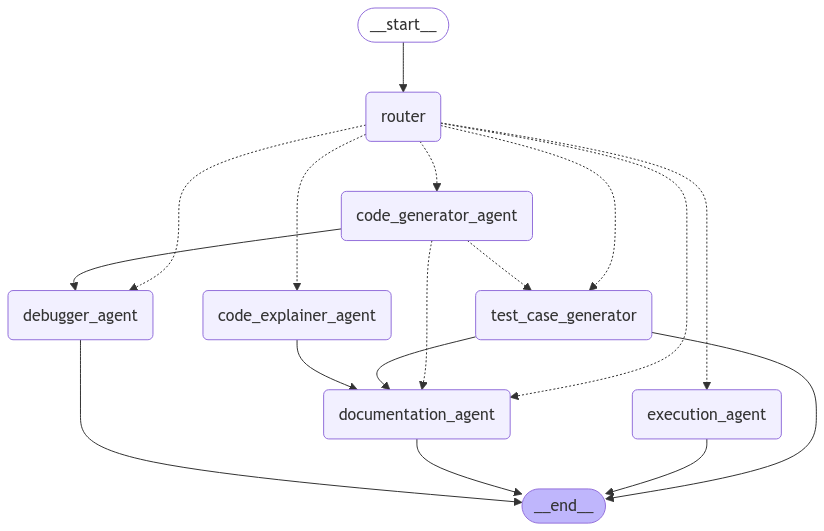

In [13]:
from IPython.display import Image

Image(app.get_graph(xray=True).draw_mermaid_png(output_file_path="arch.png"))

In [ ]:
inputs = {"query": """ Explain the following code inputs = {"query": "write code to find the sum of the numbers in an array"}

    # Invoke the graph with the input
    result = app.invoke(inputs)
    print(result)"""}

# Invoke the graph with the input
result = app.invoke(inputs)

In [8]:
# Define the input state
inputs = {"query":"""Run the following code

import time

def fibonacci_recursive(n):
    if n <= 0:
        return 0
    elif n == 1:
        return 1
    return fibonacci_recursive(n - 1) + fibonacci_recursive(n - 2)

def fibonacci_iterative(n):
    if n <= 0:
        return 0
    elif n == 1:
        return 1

    a, b = 0, 1
    for _ in range(2, n + 1):
        a, b = b, a + b
    return b

n = 20  # Adjust for larger values

# Measure recursive approach
start_time = time.time()
fib_recursive = fibonacci_recursive(n)
recursive_time = time.time() - start_time

# Measure iterative approach
start_time = time.time()
fib_iterative = fibonacci_iterative(n)
iterative_time = time.time() - start_time

print(f"Fibonacci({n}) Recursive: {fib_recursive}, Time: {recursive_time:.6f} sec")
print(f"Fibonacci({n}) Iterative: {fib_iterative}, Time: {iterative_time:.6f} sec")
"""
}

# Invoke the graph with the input
result = app.invoke(inputs)
# Markdown(result['explanation'])


In [12]:
Markdown(result['code'])

Fibonacci(20) Recursive: 6765, Time: 0.001581 sec
Fibonacci(20) Iterative: 6765, Time: 0.000005 sec

In [12]:
inputs = {"query": """ Explain the following code inputs = {"query": "write code to find the sum of the numbers in an array"}

    # Invoke the graph with the input
    result = app.invoke(inputs)
    print(result)"""}

# Invoke the graph with the input
result = app.invoke(inputs)

# Documentation

The following code snippet is used to process a specific task using an application. This could be an AI model or a function.

```python
inputs = {"query": "write code to find the sum of the numbers in an array"}
result = app.invoke(inputs)
print(result)
```

## Code Explanation

1. **Task Definition**: The task is defined in the `inputs` dictionary. The key is `query` and the value is `"write code to find the sum of the numbers in an array"`. This could be a command for an AI model to generate a code snippet that calculates the sum of numbers in an array.

2. **Application Invocation**: The `app.invoke(inputs)` line is where the application processes the task. The result of this process is stored in the `result` variable.

3. **Output Display**: The `print(result)` line is used to display the output of the application's process. This could be a code snippet generated by the AI model based on the input query.

In [13]:
!pip install gradio

In [14]:
inputs = {"query": """ Explain the following code inputs = {"query": "write code to find the sum of the numbers in an array"}

    # Invoke the graph with the input
    result = app.invoke(inputs)
    print(result)"""}

# Invoke the graph with the input
result = app.invoke(inputs)

--User Query Agent--
--Code Explainer Agent--
--Documentation Agent--


# Documentation

The following code snippet is designed to process a specific task using an application, which could be an AI model or a function.

```python
inputs = {
    "query": "write code to find the sum of the numbers in an array"
}

result = app.invoke(inputs)

print(result)
```

## Code Explanation

1. **Defining the Task**: The task is defined in the `inputs` dictionary. The key 'query' and the value "write code to find the sum of the numbers in an array" together form the task. This could be a command for an AI to generate a piece of code that calculates the sum of numbers in an array.

```python
inputs = {
    "query": "write code to find the sum of the numbers in an array"
}
```

2. **Invoking the Application**: The `app.invoke(inputs)` line is where the application is called to process the task. The result of this operation is stored in the 'result' variable.

```python
result = app.invoke(inputs)
```

3. **Displaying the Result**: The `print(result)` statement is used to display the output of the operation. This could be the generated code or an error message if the operation was not successful.

```python
print(result)
```

This code is a simple example of how an application can be used to process a task and display the result. The task can be modified by changing the value of the 'query' key in the 'inputs' dictionary.

None


In [15]:
inputs = {"query": """generate a python code to check pallindrome"""}

# Invoke the graph with the input
result = app.invoke(inputs)

--User Query Agent--
--Code Generator Agent--
--Debugger Agent--
--Documentation Agent--


# Palindrome Checker in Python

This is a simple Python script that checks if a given string is a palindrome.

## Code

```python
def is_palindrome(s):
    return s == s[::-1]

s = input("Enter a string: ")
if is_palindrome(s):
    print(s, "is a palindrome")
else:
    print(s, "is not a palindrome")
```

## How it works

The script defines a function `is_palindrome(s)` that takes a string `s` as input and returns `True` if the string is a palindrome and `False` otherwise.

The function works by comparing the original string `s` with its reverse `s[::-1]`. In Python, `s[::-1]` is a common idiom for creating a reversed copy of a string or list.

After defining the function, the script prompts the user to enter a string. It then calls `is_palindrome(s)` with the user's input and prints a message indicating whether the input is a palindrome.

## Example

If you run the script and enter "radar", it will print "radar is a palindrome". If you enter "hello", it will print "hello is not a palindrome".

None


In [17]:
import gradio as gr
from langchain_openai import ChatOpenAI

# Initialize LLM
llm = ChatOpenAI(model="gpt-4", temperature=0)

def agent_interface(user_input):
    """Process user input through the LangGraph agent workflow."""
    inputs = {"query": user_input}
    result = app.invoke(inputs)
    return result['code']

# Create Gradio Interface
demo = gr.Interface(
    fn=agent_interface,
    inputs=[
        gr.Textbox(lines=5, placeholder="Enter your coding query..."),
    ],
    outputs=gr.Textbox(),
    title="AI-Powered Code Agent",
    description="Generate, debug, optimize, and secure code using an AI agent."
)

demo.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://acf4989b2b6ee99c68.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
